# Olympic Medal Prediction - EDA and Feature Engineering

## 1. Setup and Load Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

try:
    df = pd.read_pickle('olympic_data_raw.pkl')
    print(f"Data loaded successfully: {df.shape}")
    print(f"Medal rate: {df['has_medal'].mean():.1%}")
except FileNotFoundError:
    print("Please run the setup notebook first to extract and save the data.")
    raise

Data loaded successfully: (21398, 19)
Medal rate: 10.8%


## 2. Exploratory Data Analysis

In [22]:
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nColumns and Data Types:")
for i, (col, dtype) in enumerate(zip(df.columns, df.dtypes), 1):
    print(f"   {i:2d}. {col:<25} ({dtype})")

Dataset Overview:
Shape: (21398, 19)

Columns and Data Types:
    1. athleteID                 (int64)
    2. athlete_name              (object)
    3. height                    (float64)
    4. weight                    (float64)
    5. bodyFat                   (float64)
    6. heartRateVariability      (float64)
    7. vo2Max                    (float64)
    8. bloodOxygen               (float64)
    9. injurySeverityScore       (float64)
   10. country                   (object)
   11. gdp                       (float64)
   12. population                (int64)
   13. country_year              (int64)
   14. ranking                   (int64)
   15. participation_year        (int64)
   16. event_name                (object)
   17. sportName                 (object)
   18. medal_category            (object)
   19. has_medal                 (int64)


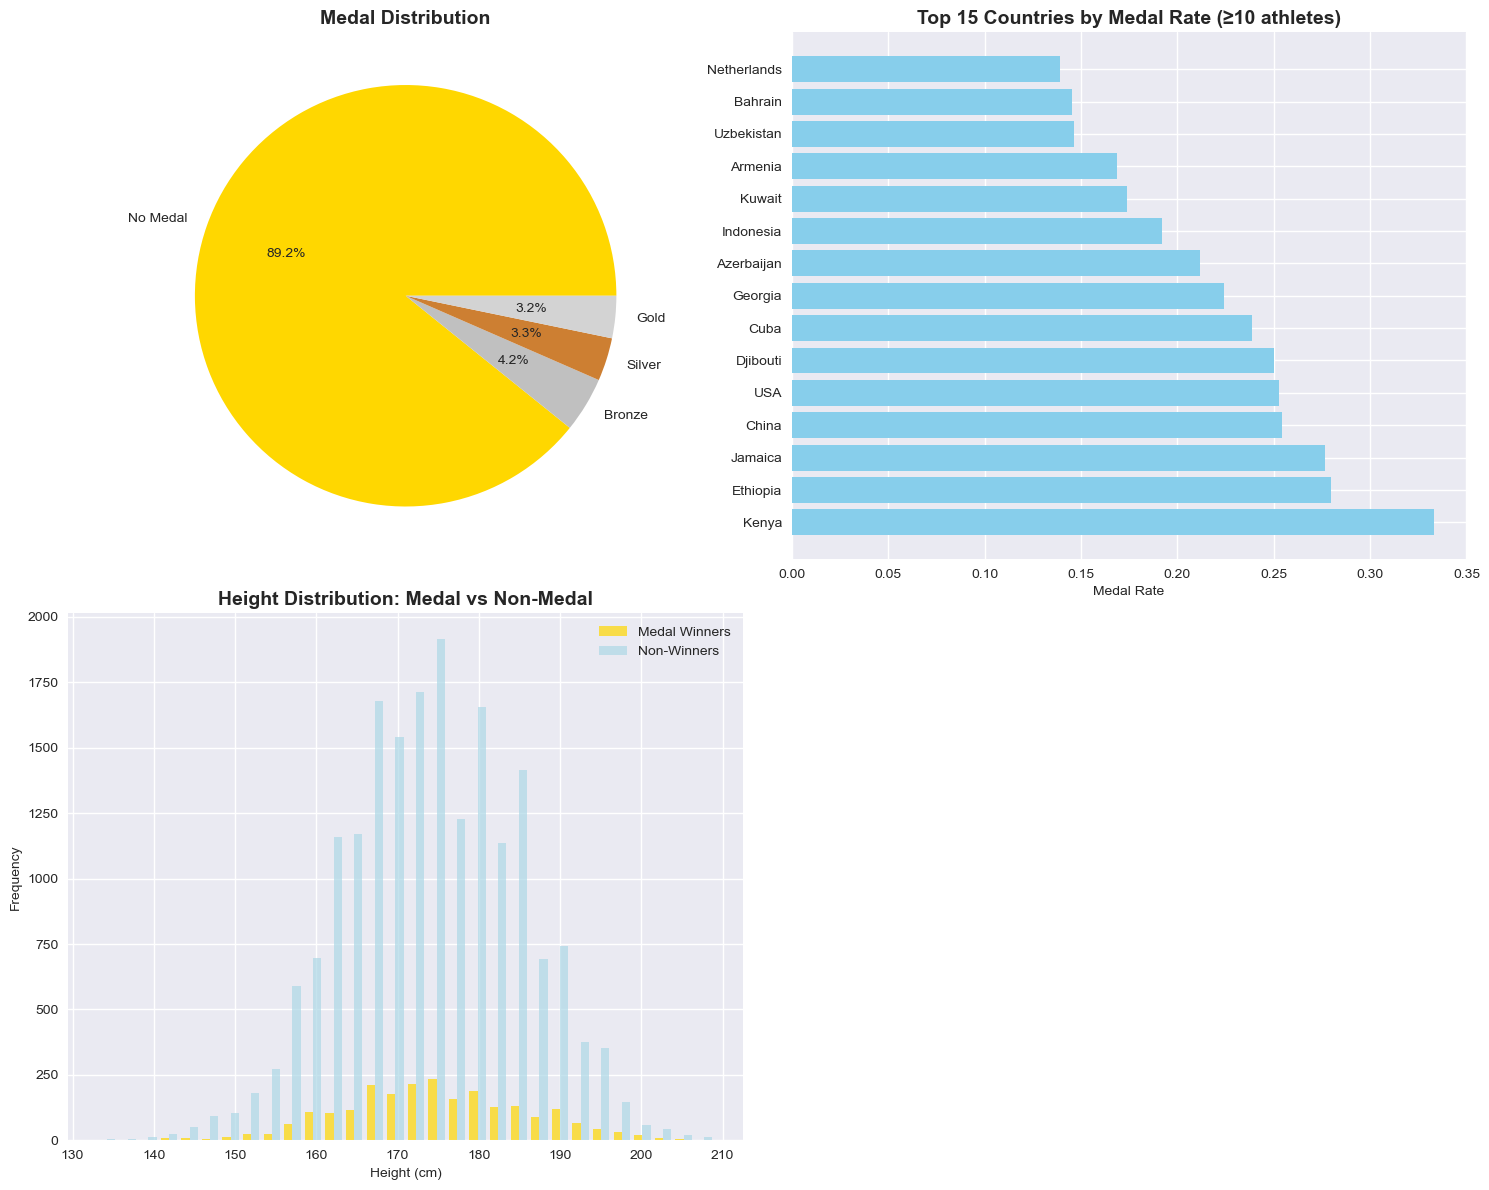

Basic EDA completed!


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

medal_counts = df['medal_category'].value_counts()
colors = ['gold', 'silver', '#CD7F32', 'lightgray']
axes[0, 0].pie(medal_counts.values, labels=medal_counts.index, autopct='%1.1f%%', colors=colors)
axes[0, 0].set_title('Medal Distribution', fontsize=14, fontweight='bold')

country_medals = df.groupby('country')['has_medal'].agg(['mean', 'count']).query('count >= 10').sort_values('mean', ascending=False).head(15)
axes[0, 1].barh(range(len(country_medals)), country_medals['mean'], color='skyblue')
axes[0, 1].set_yticks(range(len(country_medals)))
axes[0, 1].set_yticklabels(country_medals.index, fontsize=10)
axes[0, 1].set_title('Top 15 Countries by Medal Rate (≥10 athletes)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Medal Rate')

medal_winners = df[df['has_medal'] == 1]['height'].dropna()
non_winners = df[df['has_medal'] == 0]['height'].dropna()
axes[1, 0].hist([medal_winners, non_winners], bins=30, alpha=0.7, 
                label=['Medal Winners', 'Non-Winners'], color=['gold', 'lightblue'])
axes[1, 0].set_title('Height Distribution: Medal vs Non-Medal', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Height (cm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].remove()

plt.tight_layout()
plt.show()

print("Basic EDA completed!")

## 3. Feature Engineering

In [24]:
df_features = df.copy()

df_features['gdp_per_capita'] = df_features['gdp'] / df_features['population']
df_features['bmi'] = df_features['weight'] / ((df_features['height'] / 100) ** 2)
df_features['height_weight_ratio'] = df_features['height'] / df_features['weight']

df_features['estimated_age'] = 20 + (df_features['participation_year'] - 2008) * 0.3

df_features['fitness_score'] = (
    df_features['vo2Max'] * 0.4 + 
    df_features['bloodOxygen'] * 0.3 + 
    (100 - df_features['bodyFat']) * 0.2 +
    df_features['heartRateVariability'] * 0.1
)

df_features['risk_score'] = (
    df_features['injurySeverityScore'] * 0.6 +
    df_features['bodyFat'] * 0.4
)

print("Basic features created: gdp_per_capita, bmi, height_weight_ratio, estimated_age, fitness_score, risk_score")

Basic features created: gdp_per_capita, bmi, height_weight_ratio, estimated_age, fitness_score, risk_score


In [25]:
country_stats = df_features.groupby('country').agg({
    'has_medal': ['mean', 'count', 'sum'],
    'ranking': 'mean',
    'gdp_per_capita': 'mean'
}).round(4)

country_stats.columns = [
    'country_medal_rate', 'country_total_athletes', 'country_total_medals',
    'country_avg_ranking', 'country_avg_gdp_per_capita'
]
country_stats = country_stats.reset_index()

df_features = df_features.merge(country_stats, on='country', how='left')

print("Country performance features created")

Country performance features created


In [26]:
sport_stats = df_features.groupby('sportName').agg({
    'has_medal': ['mean', 'count'],
    'ranking': 'mean',
    'fitness_score': 'mean'
}).round(4)

sport_stats.columns = [
    'sport_medal_rate', 'sport_total_participants', 
    'sport_avg_ranking', 'sport_avg_fitness'
]
sport_stats = sport_stats.reset_index()

df_features = df_features.merge(sport_stats, on='sportName', how='left')

print(f"Total features created: {df_features.shape[1]}")

Total features created: 34


## 4. Feature Selection for Modeling

In [27]:
feature_columns = [
    'height', 'weight', 'bmi', 'bodyFat', 'heartRateVariability', 
    'vo2Max', 'bloodOxygen', 'injurySeverityScore',
    'fitness_score', 'risk_score', 'estimated_age',
    'gdp_per_capita', 'country_medal_rate', 'country_avg_ranking', 
    'sport_medal_rate', 'sport_avg_ranking'
]

available_features = [col for col in feature_columns if col in df_features.columns]

X = df_features[available_features].copy()
y = df_features['has_medal'].copy()

X = X.fillna(X.median())

print(f"Selected {len(available_features)} features for modeling")
print(f"Feature matrix shape: {X.shape}")
print(f"Medal rate: {y.mean():.1%}")

Selected 16 features for modeling
Feature matrix shape: (21398, 16)
Medal rate: 10.8%


## 5. Feature Statistics and Correlations

In [28]:
print("Feature Statistics:")
display(X.describe())

correlation_features = available_features + ['has_medal']
correlation_data = df_features[correlation_features].copy()
correlation_matrix = correlation_data.corr()

medal_correlations = correlation_matrix['has_medal'].drop('has_medal').sort_values(key=abs, ascending=False)
print("\nStrongest Correlations with Medal Success:")
for feature, corr in medal_correlations.head(8).items():
    print(f"   {feature}: {corr:.3f}")

Feature Statistics:


,height,weight,bmi,bodyFat,heartRateVariability,vo2Max,bloodOxygen,injurySeverityScore,fitness_score,risk_score,estimated_age,gdp_per_capita,country_medal_rate,country_avg_ranking,sport_medal_rate,sport_avg_ranking
count,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000,21398.000000
mean,174.189363,69.238013,22.592402,10.671507,69.844696,67.349442,97.988929,1.955323,81.186624,5.441797,21.531209,26589.929657,0.107860,19.348623,0.107855,19.348625
std,10.865410,16.177890,3.568063,2.879587,17.482459,7.325549,1.155556,1.973173,3.516161,1.653201,1.229936,23050.523297,0.071042,4.905441,0.052927,8.035899
min,133.000000,28.000000,14.681440,6.001996,40.015532,45.088670,96.000034,0.000000,67.610388,2.400798,20.000000,194.710635,0.000000,7.571400,0.000000,1.000000
25%,167.000000,58.000000,20.312500,8.345110,54.537326,61.237772,96.996453,1.000000,78.629858,4.239794,20.000000,6300.582180,0.067700,16.941600,0.082000,14.520400
50%,174.000000,67.000000,22.024323,10.590755,70.307325,67.251841,97.993345,1.000000,81.175624,5.309296,21.200000,17886.733165,0.090200,19.215600,0.106600,16.450000
75%,182.000000,78.000000,24.023809,12.857757,84.903299,73.632675,98.975398,3.000000,83.816348,6.351259,22.400000,45461.583751,0.130200,21.520500,0.116000,23.121900
max,209.000000,170.000000,51.789235,24.969409,99.995447,79.998154,99.999209,10.000000,89.931325,14.662558,23.600000,204097.113958,0.333300,66.000000,1.000000,37.966100



Strongest Correlations with Medal Success:
   country_medal_rate: 0.229
   country_avg_ranking: -0.174
   sport_medal_rate: 0.171
   sport_avg_ranking: -0.138
   weight: 0.043
   bmi: 0.041
   estimated_age: 0.028
   height: 0.023


## 6. Save Processed Data

In [29]:
X.to_pickle('features_X.pkl')
y.to_pickle('target_y.pkl')
df_features.to_pickle('olympic_data_processed.pkl')

import pickle
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(available_features, f)
